In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import time
import datetime
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import itertools
from itertools import groupby
from pyecharts.charts import Bar, Pie, Map, WordCloud, Geo
from pyecharts import options as opts
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from pyecharts.globals import ChartType, SymbolType
from pyecharts.commons.utils import JsCode
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

import import_ipynb
from utils_common import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")

importing Jupyter notebook from utils_common.ipynb


In [2]:
# Where to save the dataframes and figures
_Figure_PATH_ = './figures/'

## Figures

In [3]:
# plot the confirmed cases
def figure_conf(df, figsize = (8,5), fs = 15, logy = False, title = None, rank = 0):
    
    sns.set_style("whitegrid")
    palette = plt.get_cmap('magma')
    
    fig = plt.figure()
    plot_df = df.groupby('update_date').agg('sum')
 
    ax1 = fig.add_subplot(111)
    plot_df.plot(y = ['cum_confirmed'], style = '-', marker = 'o', ax = ax1, 
                 figsize = figsize, logy = logy, color = palette(rank/50 + 0.2)) # grid = False, 
    ax1.set_ylabel("Number of people (cum)", fontsize = fs - 2)
    ax1.set_xticks([]) # hide the axes ticks
    plt.legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
    ax11 = ax1.twinx()
    ax11.bar(x = plot_df.index, height = plot_df['new_confirmed'], color = palette(rank/50 + 0.2), alpha = 0.8)
    
    ax11.set_ylabel('Number of people (daily)', fontsize = fs - 2)
    ax11.grid(False) # hide grid lines
    
    ax1.set_xlabel("Date", fontsize = fs - 2)
    
    daily_patch = mpatches.Patch(color = palette(rank/50 + 0.2), label='daily_confirmed')
    plt.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.9), fancybox=True, fontsize = fs - 2)

    if title is not None:
        fig.suptitle(title, fontsize = fs, y = 1)     
    return fig
    
# plot the confirmed, the dead, and the cured cases
def figure_conf_dead_cured(df, fsize=(10,8), fs=18, title=None):
    
    sns.set_style("whitegrid")
    palette = ["#50a3ba", "#eac763", "#d94e5d"] # from pyecharts
    #palette = [ '#79a7ac', '#bd925a', '#d98994'] # earth and tealrose
    
    fig = plt.figure(figsize=fsize)
    plot_df = df.groupby('update_date').agg('sum')
    plot_df.reset_index(level=0, inplace=True)
 
    ax1 = fig.add_subplot(211)
    ax1.plot(plot_df['update_date'], plot_df['cum_confirmed'], marker = 'o', color = palette[2], 
             label = 'cumulative infected') # grid = False, 
    ax1.set_xticks([]) # hide the axes ticks
    ax1.set_ylabel("Number of people (cum)", fontsize = fs - 2)
    ax1.legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
    ax11 = ax1.twinx()
    ax11.bar(x = plot_df['update_date'], height = plot_df['new_confirmed'], color = palette[2], alpha = 0.8)
    
    ax11.set_ylabel('Number of people (new)', fontsize = fs - 2)
    ax11.grid(False) # hide grid lines
    daily_patch = mpatches.Patch(color = palette[2], label='new infected')
    ax11.legend(handles = [daily_patch], loc='upper right', fancybox = True, fontsize = fs - 2)
    
    ax2 = fig.add_subplot(212)
    ax2.plot(plot_df['update_date'], plot_df['cum_cured'], marker = 'o', 
             color = palette[0], label = 'recovered') # cured
    plt.legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
    ax22 = ax2.twinx()
    ax22.plot(plot_df['update_date'], plot_df['cum_dead'], marker = 'o',
              color = palette[1], label = 'dead')
    ax22.set_ylabel('Number of people dead', fontsize = fs - 2)
    ax22.grid(False) # hide grid lines
    
    ax2.set_xlabel("Date", fontsize = fs - 2)
    ax2.set_ylabel("Number of people recovered", fontsize = fs - 2)
    
    ax1.set_xlim(min(df.update_date), max(df.update_date))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax2.set_xlim(min(df.update_date), max(df.update_date))
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    plt.legend(loc = 'upper right', fancybox = True, fontsize = fs - 2)
    # align labels
    ax1.get_yaxis().set_label_coords(-0.1,0.5)
    ax2.get_yaxis().set_label_coords(-0.1,0.5)
    ax11.get_yaxis().set_label_coords(1.1,0.5)
    ax22.get_yaxis().set_label_coords(1.1,0.5)
    
    if title is not None:
        fig.suptitle(title, fontsize = fs, y = 1.01) 
    fig.savefig(_Figure_PATH_ + 'figures_china/' + 'China_' + 'summary.png', dpi = 400, bbox_inches='tight')
    return fig

In [4]:
# plot the confirmed cases for every province
def figure_conf_all(df, names_province, fsize = (5, 3), ncol = 3, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'China'):
    
    sns.set_style("ticks")
    palette = plt.get_cmap('Reds')
    
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    df_rank = df[df['update_date'] == max(df['update_date'])].copy()
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    for i, province in enumerate(names_province):
        
        ix = np.unravel_index(i, axes.shape)
        c = palette(rank_list.index(i)/2/m + 0.3)
        
        plot_df = df[df['province_name_en'] == province]
        
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = (lambda x: None if x > 0 else 'cum')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number (cum)', fontsize = fs - 2)
            axes[ix].get_yaxis().set_label_coords(-0.15,0.5)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
        axes[ix].set_title(province, fontsize = fs)
     
    fig.align_ylabels(axes[:, 0])
    
    for i, province in enumerate(names_province):   
        ix = np.unravel_index(i, axes.shape)
        c = palette(rank_list.index(i)/2/m + 0.3)
        
        plot_df = df[df['province_name_en'] == province]
        ax11 = axes[ix].twinx()
        ax11.grid(False) # hide grid lines
        ax11.bar(plot_df['update_date'], height = plot_df['new_confirmed'], color = c, alpha = 0.8,
                label = (lambda x: None if x > 0 else 'new_confirmed')(i))
        daily_patch = mpatches.Patch(color = c, label='new')
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper right', fancybox=True, fontsize = fs - 2)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Number (new)', fontsize = fs - 2)
            ax11.get_yaxis().set_label_coords(1.1, 0.5)
        
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
    
    fig.savefig(_Figure_PATH_ + 'figures_china/' + country + '_infection.png', dpi = 400, bbox_inches='tight')

🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄🎄

In [5]:
# functions imported from utils_common
data_city, data_province, data_province_domestic = load_DXY_raw()

In [6]:
# the date is truncated to March 10, 2020
date_tr = datetime.date(int(2020),int(3),int(10))
data_province_domestic = data_province_domestic[data_province_domestic.update_date <= date_tr]

In [7]:
min(data_province_domestic['update_date']), max(data_province_domestic['update_date'])

(datetime.date(2020, 1, 15), datetime.date(2020, 3, 10))

In [8]:
data_slice = data_province_domestic[data_province_domestic['update_date'] == datetime.date(int(2020),int(1),int(31))]
data_slice = data_slice.sort_values(by = 'province_name_en')
data_slice = data_province_domestic[data_province_domestic['province_name_en'] == 'Hubei']
data_slice = data_slice.reset_index(drop = True)
data_slice

,update_date,province_name,province_name_en,province_zip_code,cum_confirmed,cum_cured,cum_dead,new_confirmed,new_cured,new_dead,update_time
0,2020-01-15,湖北省,Hubei,420000,41.0,7.0,1.0,41.0,7.0,1.0,NaN
1,2020-01-16,湖北省,Hubei,420000,41.0,12.0,2.0,0.0,5.0,1.0,NaN
2,2020-01-17,湖北省,Hubei,420000,45.0,15.0,2.0,4.0,3.0,0.0,NaN
3,2020-01-18,湖北省,Hubei,420000,62.0,19.0,2.0,17.0,4.0,0.0,NaN
4,2020-01-19,湖北省,Hubei,420000,121.0,24.0,3.0,59.0,5.0,1.0,NaN
5,2020-01-20,湖北省,Hubei,420000,198.0,25.0,3.0,77.0,1.0,0.0,NaN
6,2020-01-21,湖北省,Hubei,420000,270.0,25.0,6.0,72.0,0.0,3.0,NaN
7,2020-01-22,湖北省,Hubei,420000,375.0,28.0,9.0,105.0,3.0,3.0,NaN
8,2020-01-23,湖北省,Hubei,420000,444.0,28.0,17.0,69.0,0.0,8.0,NaN
9,2020-01-24,湖北省,Hubei,420000,549.0,31.0,24.0,105.0,3.0,7.0,2020-01-24 17:30:09.978000


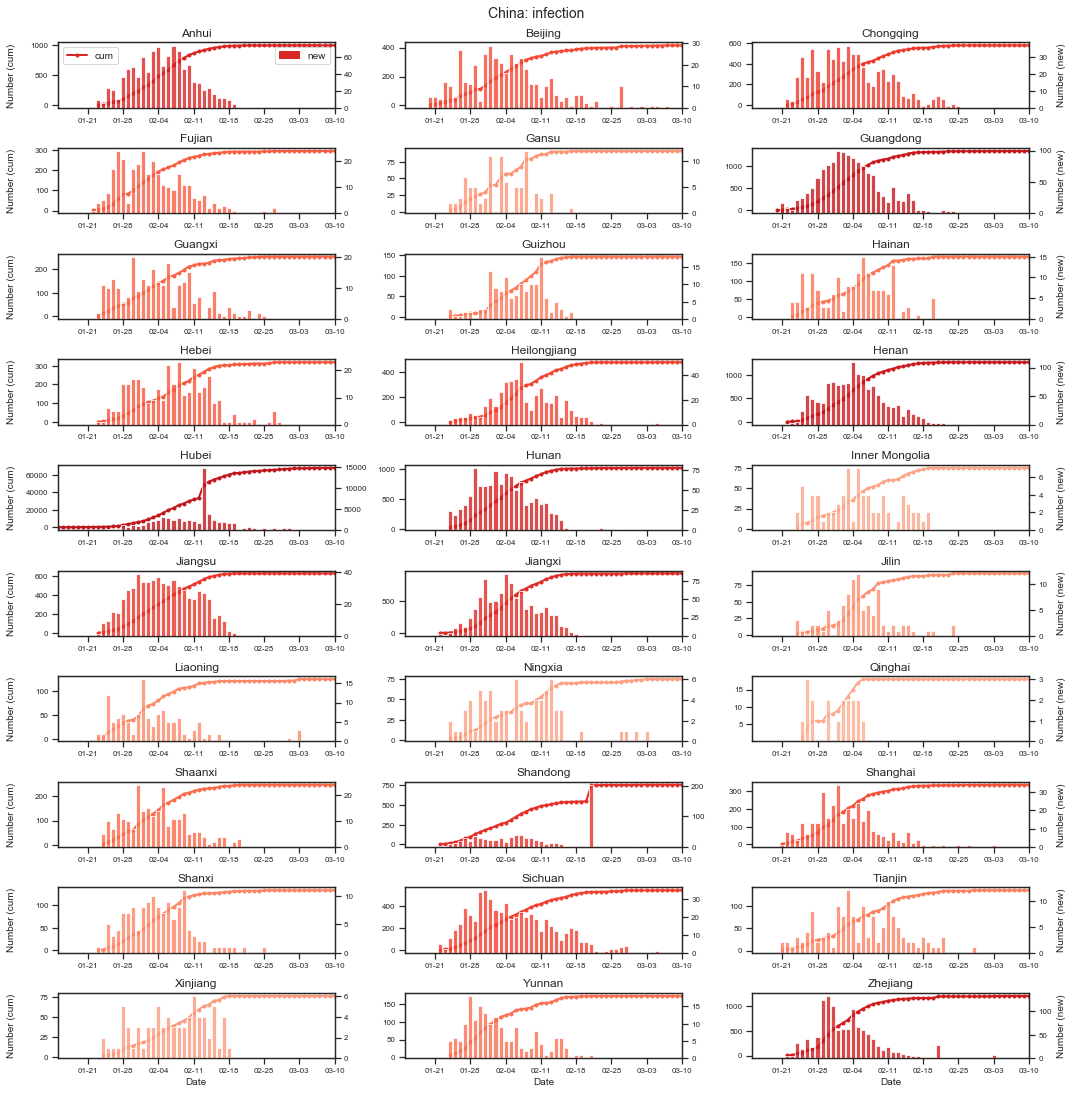

In [9]:
figure_conf_all(df = data_province_domestic, names_province = names_province, 
                fsize = (5, 1.5), ncol = 3, ms = 3, fs = 12, logy = False, 
                title = 'China: infection', country = 'China')

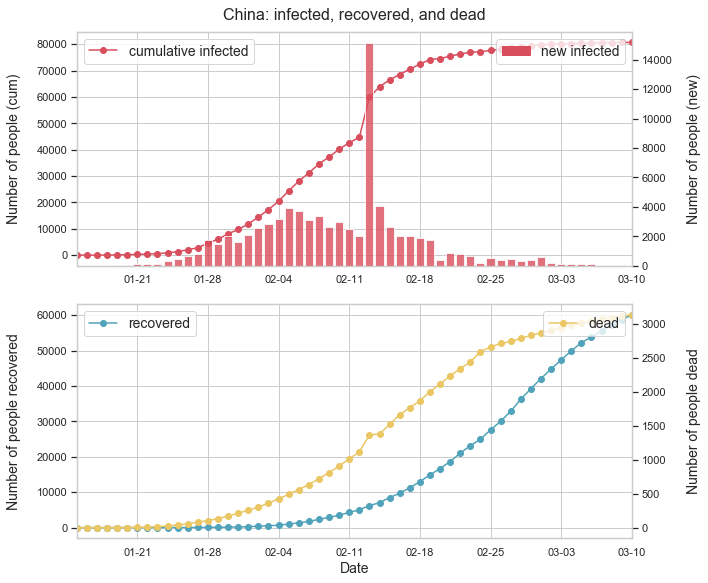

In [49]:
fig = figure_conf_dead_cured(data_province_domestic, fsize = (10, 8), fs = 16, 
                             title = 'China: infected, recovered, and dead') # confirmed, cured, and dead

In [10]:
#province = 'Hubei' # target province
#fig = figure_conf_dead_cured(data_province[data_province['province_name_en'] == province], title = province + ': confirmed, cured, and dead')
#plt.show()

In [11]:
#city = 'Wuhan' # target city
#fig = figure_conf_dead_cured(data_city[data_city['city_name_en'] == city], logy = False, title = city + ': confirmed, cured, and dead')
#plt.show()  

In [70]:
# plot a specific column: confirmed, cured or dead
def figure_bar(df, date_str, col, largestN = 0, log = True, figsize = (12, 8), fs = 18, title = None):
    
    sns.set_style("whitegrid")
    year, month, day = date_str.split('-')
    
    date = datetime.date(int(year),int(month),int(day))
    if date_str is not None:
        df_single = df[df['update_date'] == date]
    else:
        df_single = df
        
    df_single = df_single[df_single['province_name_en'].isin(names_province)]
    df_single = df_single.sort_values(by = col)
    df_single = df_single.reset_index(drop = True)
        
    if largestN > 0:
        df_single = df_single[-largestN:]  # only plot the first N bars
    else:
        largestN = df_single.shape[0]
    
    cmap_dict = {'cum_confirmed': tealrose, 'new_confirmed': tealrose, 
                 'cum_cured': armyrose, 'new_cured': armyrose, 
                 'cum_dead': earth, 'new_dead': earth,
                 'infection_rate': tealrose}
    
    palette = cmap_dict[col]
    palette = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(largestN/len(palette)))) for x in palette))
    palette = palette[:largestN]
    
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    bars = df_single[col].tolist()
    # in case zero appears
    bars = [temp if temp > 0 else 0.1 for temp in bars]
    names = df_single['province_name_en']
    ax.barh(names, bars, color = palette, height = 0.4, alpha = 0.8) # palette(np.linspace(0.2, 0.8, largestN))    
    for j, v in enumerate(bars): # add text
        ax.text(v*1.1, j - 0.2, str(int(v)), color = 'black', fontsize = fs - 6)
    ax.set_xlabel("Number of people", fontsize = fs - 2)
    ax.set_ylabel('Province', fontsize = fs - 2)
    if log == True:
        ax.set_xscale('log')
        xmin = np.power(10, np.floor(np.log10(min(bars))))
        xmax = np.power(10, np.ceil(np.log10(max(bars))))
        ax.set_xlim(xmin, xmax)
    
    dict_title = {'cum_confirmed': 'infected', 'cum_cured': 'recovered', 'cum_dead': 'dead'}
    if title is not None: # col[:3] + ' ' + col[4:]
        #fig.suptitle(title + ' ' + dict_title[col], fontsize = fs, y = (lambda x: 1.06 if x != len(names_province) else 1.035)(largestN))
        fig.suptitle(title + ' ' + dict_title[col], fontsize = fs, y = (lambda x: 1.05 if x != len(names_province) else 1.03)(largestN))
    plt.figtext(0.85, 1, 'by ' + date.strftime("%d %B, %Y"), ha = "center", va = "top", fontsize = fs - 4)
    if largestN != len(names_province):
        fig.savefig(_Figure_PATH_ + 'figures_china/' + 'China_bar_' + dict_title[col] + '_top.png', dpi = 400, bbox_inches='tight')
    else:
        fig.savefig(_Figure_PATH_ + 'figures_china_be/' 'China_bar_' + dict_title[col] + '.png', dpi = 400, bbox_inches='tight')
    return fig

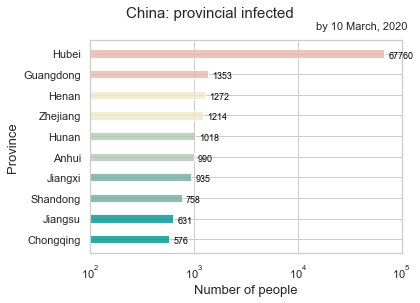

In [60]:
fig = figure_bar(df = data_province_domestic, date_str = '2020-03-10', 
                 col = 'cum_confirmed', largestN = 10, log = True, figsize = (6, 4), fs = 15, 
                 title = 'China: provincial')

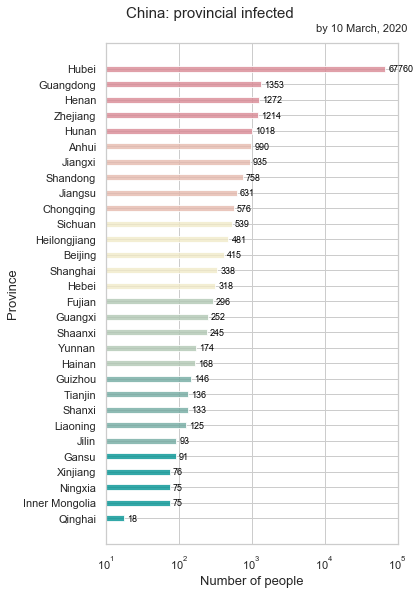

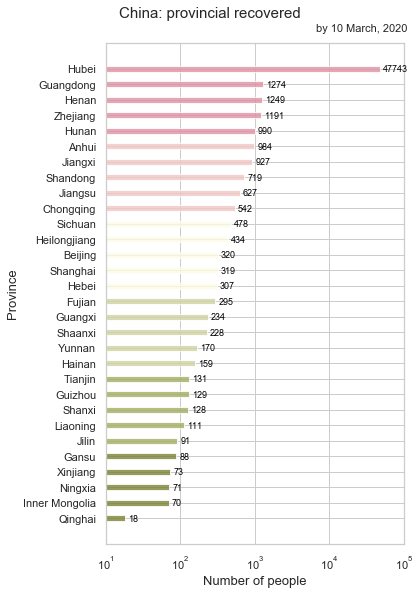

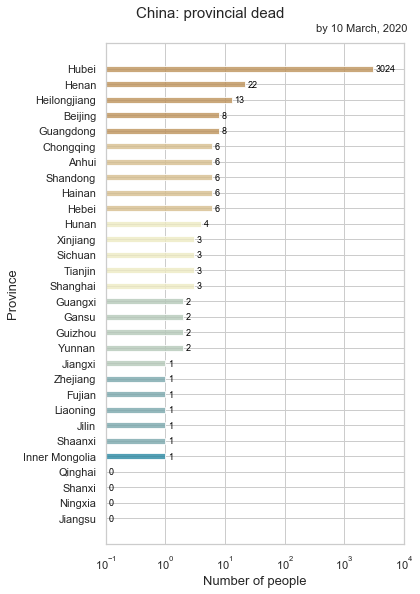

In [71]:
# province level
fig = figure_bar(df = data_province_domestic, date_str = '2020-03-10', 
                 col = 'cum_confirmed', largestN = 0, log = True, figsize = (6, 8), fs = 15, 
                 title = 'China: provincial')
fig = figure_bar(df = data_province_domestic, date_str = '2020-03-10', 
                 col = 'cum_cured', largestN = 0, log = True, figsize = (6, 8), fs = 15, 
                 title = 'China: provincial')
fig = figure_bar(df = data_province_domestic, date_str = '2020-03-10', 
                 col = 'cum_dead', largestN = 0, log = True, figsize = (6, 8), fs = 15, 
                 title = 'China: provincial')

In [63]:
# city level
#fig = figure_bar(data_city, '2020-03-10', col = 'cum_confirmed', groupby = 'province_name_en',title = 'National')

In [64]:
#fig = figure_bar(data_city, '2020-03-10', col = 'new_confirmed', groupby = 'city_name_en', largestN = 10, title='Top 10 City')

In [65]:
# city level in Hubei province
#fig = figure_bar(data_city[data_city['province_name_en'] == 'Hubei'], '2020-02-01', col = 'cum_dead', groupby = 'city_name_en', title = 'Hubei Province')

In [66]:
# Compare the population size with the infection size
# infection ratio (per mille)
infection_ratio = [(name, round(data_province_domestic[(data_province_domestic.province_name_en == name) & (data_province_domestic.update_date <= date_tr)].cum_confirmed.max()/provincial_population_dict.get(name)*1e6, 3)) for name in names_province]
# conclusion: in the SEIR model, S + E is approximately N
# min(infection_ratio, key = lambda t: t[1]), max(infection_ratio, key = lambda t: t[1])
infection_ratio = pd.DataFrame.from_records(infection_ratio, columns =['province_name_en', 'ratio']) 

In [67]:
infection_ratio

,province_name_en,ratio
0,Anhui,15.656
1,Beijing,19.265
2,Chongqing,18.570
3,Fujian,7.511
4,Gansu,3.451
5,Guangdong,11.925
6,Guangxi,5.116
7,Guizhou,4.056
8,Hainan,17.981
9,Hebei,4.208


In [74]:
# ir stands for infection ratio
def figure_ir_bar(df, update_date_tr, largestN = 0, log = True, figsize = (12, 8), fs = 18, title = None):
    
    df_single = df[df['province_name_en'].isin(names_province)]
    df_single = df_single.sort_values(by = 'ratio')
    df_single = df_single.reset_index(drop = True)
        
    if largestN > 0:
        df_single = df_single[-largestN:]  # only plot the first N bars
    else:
        largestN = df_single.shape[0]
    
    palette = plt.get_cmap('pink_r')
    palette = tealrose
    palette = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(largestN/len(palette)))) for x in palette))
    palette = palette[:largestN]
    sns.set_style("whitegrid")
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    bars = df_single['ratio'].tolist()
    names = df_single['province_name_en']
    ax.barh(names, bars, color = palette, height = 0.4, alpha = 0.8) # palette(np.linspace(0.2, 0.8, largestN))
    for j, v in enumerate(bars): # add text
        ax.text(v*1.1, j - 0.2, str(round(v)), color = 'black', fontsize = fs - 6)
    ax.set_xlabel("Infection rate (per million)", fontsize = fs - 2)
    ax.set_ylabel('Province', fontsize = fs - 2)
    if log == True:
        ax.set_xscale('log')
        xmin = 1
        xmax = 1e4
        ax.set_xlim(xmin, xmax)
        
    if title is not None:
        fig.suptitle(title, fontsize = fs, y = 1.03)
    #plt.figtext(0.5, 1, update_date_tr.strftime("%d %B, %Y"), ha = "center", va = "top", fontsize = fs - 4)
    plt.figtext(0.85, 1, 'by ' + update_date_tr.strftime("%d %B, %Y"), ha = "center", va = "top", fontsize = fs - 4)
    fig.savefig(_Figure_PATH_ + 'figures_china_be/' + 'China_infection_rate.png', dpi = 400, bbox_inches='tight')
    return fig

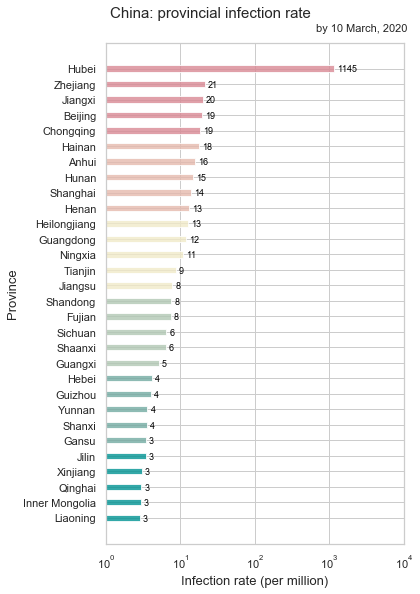

In [75]:
fig = figure_ir_bar(df = infection_ratio, update_date_tr = date_tr, largestN = 0, log = True, figsize = (6, 8), fs = 15, 
                    title = 'China: provincial infection rate')

In [76]:
# a dictionary for the pyecharts geo maps
d = {'湖北': 'Hubei',
 '广东': 'Guangdong',
 '河南': 'Henan',
 '浙江': 'Zhejiang',
 '湖南': 'Hunan',
 '安徽': 'Anhui',
 '江西': 'Jiangxi',
 '山东': 'Shandong',
 '江苏': 'Jiangsu',
 '重庆': 'Chongqing',
 '四川': 'Sichuan',
 '黑龙江': 'Heilongjiang',
 '北京': 'Beijing',
 '上海': 'Shanghai',
 '河北': 'Hebei',
 '福建': 'Fujian',
 '广西': 'Guangxi',
 '陕西': 'Shaanxi',
 '云南': 'Yunnan',
 '海南': 'Hainan',
 '贵州': 'Guizhou',
 '天津': 'Tianjin',
 '山西': 'Shanxi',
 '辽宁': 'Liaoning',
 '吉林': 'Jilin',
 '甘肃': 'Gansu',
 '新疆': 'Xinjiang',
 '宁夏': 'Ningxia',
 '内蒙古': 'Inner Mongolia',
 '青海': 'Qinghai'}
#for k, v in d.items():
    #print ('if(params.name == \'' + k + '\')' + '\n' + '    ' + 
                #'return \'' + v + '\' + \' : \' + ' + 'params.value[2];')

In [89]:
# geo maps
def figure_map_png(df, end_date, pieces, vr_upper = 0, fs = 20, subject = 'scatter'):
    
    data_single = df[df.update_date == end_date]
    data_single = data_single.sort_values(by='cum_confirmed', ascending=False)
    data_single = data_single.reset_index(drop=True)
    # for the scatter plot or heatmap
    provinces = data_single.province_name
    provinces = [pyecharts_province_dict[temp] for temp in provinces]
    values = data_single.cum_confirmed
    fn = """
    function(params) {
        return params.name + ' : ' + params.value[2]
    }
    """
    # show province names and values
    fn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei' + ' : ' + params.value[2];
        if(params.name == '广东')
            return 'Guangdong' + ' : ' + params.value[2];
        if(params.name == '河南')
            return 'Henan' + ' : ' + params.value[2];
        if(params.name == '浙江')
            return 'Zhejiang' + ' : ' + params.value[2];
        if(params.name == '湖南')
            return 'Hunan' + ' : ' + params.value[2];
        if(params.name == '安徽')
            return 'Anhui' + ' : ' + params.value[2];
        if(params.name == '江西')
            return 'Jiangxi' + ' : ' + params.value[2];
        if(params.name == '山东')
            return 'Shandong' + ' : ' + params.value[2];
        if(params.name == '江苏')
            return 'Jiangsu' + ' : ' + params.value[2];
        if(params.name == '重庆')
            return 'Chongqing' + ' : ' + params.value[2];
        if(params.name == '四川')
            return 'Sichuan' + ' : ' + params.value[2];
        if(params.name == '黑龙江')
            return 'Heilongjiang' + ' : ' + params.value[2];
        if(params.name == '北京')
            return 'Beijing' + ' : ' + params.value[2];
        if(params.name == '上海')
            return 'Shanghai' + ' : ' + params.value[2];
        if(params.name == '河北')
            return 'Hebei' + ' : ' + params.value[2];
        if(params.name == '福建')
            return 'Fujian' + ' : ' + params.value[2];
        if(params.name == '广西')
            return 'Guangxi' + ' : ' + params.value[2];
        if(params.name == '陕西')
            return 'Shaanxi' + ' : ' + params.value[2];
        if(params.name == '云南')
            return 'Yunnan' + ' : ' + params.value[2];
        if(params.name == '海南')
            return 'Hainan' + ' : ' + params.value[2];
        if(params.name == '贵州')
            return 'Guizhou' + ' : ' + params.value[2];
        if(params.name == '天津')
            return 'Tianjin' + ' : ' + params.value[2];
        if(params.name == '山西')
            return 'Shanxi' + ' : ' + params.value[2];
        if(params.name == '辽宁')
            return 'Liaoning' + ' : ' + params.value[2];
        if(params.name == '吉林')
            return 'Jilin' + ' : ' + params.value[2];
        if(params.name == '甘肃')
            return 'Gansu' + ' : ' + params.value[2];
        if(params.name == '新疆')
            return 'Xinjiang' + ' : ' + params.value[2];
        if(params.name == '宁夏')
            return 'Ningxia' + ' : ' + params.value[2];
        if(params.name == '内蒙古')
            return 'Inner Mongolia' + ' : ' + params.value[2];
        if(params.name == '青海')
            return 'Qinghai' + ' : ' + params.value[2];
    }
    """
    # show only province names
    gn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        if(params.name == '安徽')
            return 'Anhui';
        if(params.name == '江西')
            return 'Jiangxi';
        if(params.name == '山东')
            return 'Shandong';
        if(params.name == '江苏')
            return 'Jiangsu';
        if(params.name == '重庆')
            return 'Chongqing';
        if(params.name == '四川')
            return 'Sichuan';
        if(params.name == '黑龙江')
            return 'Heilongjiang';
        if(params.name == '北京')
            return 'Beijing';
        if(params.name == '上海')
            return 'Shanghai';
        if(params.name == '河北')
            return 'Hebei';
        if(params.name == '福建')
            return 'Fujian';
        if(params.name == '广西')
            return 'Guangxi';
        if(params.name == '陕西')
            return 'Shaanxi';
        if(params.name == '云南')
            return 'Yunnan';
        if(params.name == '海南')
            return 'Hainan';
        if(params.name == '贵州')
            return 'Guizhou';
        if(params.name == '天津')
            return 'Tianjin';
        if(params.name == '山西')
            return 'Shanxi';
        if(params.name == '辽宁')
            return 'Liaoning';
        if(params.name == '吉林')
            return 'Jilin';
        if(params.name == '甘肃')
            return 'Gansu';
        if(params.name == '新疆')
            return 'Xinjiang';
        if(params.name == '宁夏')
            return 'Ningxia';
        if(params.name == '内蒙古')
            return 'Inner Mongolia';
        if(params.name == '青海')
            return 'Qinghai';
    }
    """
    # show only 5 province names and values
    hn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei' + ' : ' + params.value[2];
        if(params.name == '广东')
            return 'Guangdong' + ' : ' + params.value[2];
        if(params.name == '河南')
            return 'Henan' + ' : ' + params.value[2];
        if(params.name == '浙江')
            return 'Zhejiang' + ' : ' + params.value[2];
        if(params.name == '湖南')
            return 'Hunan' + ' : ' + params.value[2];
        return '';
    }
    """
    # show only 5 province names
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    # scatter plot
    if subject == 'scatter':
        # show both province name and number of infected
        
        c = (
                Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "number of infected",
                    [list(z) for z in zip(provinces, values)],
                    #type_= ChartType.EFFECT_SCATTER,
                    color = '#d94e5d',
                    symbol_size = 10,
                    point_size = 5,
                )
                .set_series_opts(
                    label_opts = opts.LabelOpts(
                        formatter=JsCode(ln), font_size = fs - 3, color = 'black'))
                #.set_series_opts(label_opts = opts.LabelOpts(is_show = True))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)),
                    visualmap_opts = opts.VisualMapOpts(
                        is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                        pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"),
                                               title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 10),
                                               subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs)))
            )
        
        make_snapshot(snapshot, c.render(), # _Figure_PATH_ + 'figures_china/' + "China_smap.html"
                      _Figure_PATH_ + 'figures_china/' + "China_smap.png")
        return c
    # heatmap plot
    else:
        c = (
            Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"))
            .add_schema(maptype="china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                    "number of infected",
                    [list(z) for z in zip(provinces, values)],
                    color = '#d94e5d',
                    #type_= ChartType.EFFECT_SCATTER,
                    symbol_size = 8,
                    point_size = 5,
                )
            .add(
                "number of infected",
                [list(z) for z in zip(provinces, values)],
                type_ = ChartType.HEATMAP,
                symbol_size = 15,  
            )
            .set_series_opts(label_opts = opts.LabelOpts(
                        formatter = JsCode(ln), font_size = fs - 3, color = 'black'))
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)),
                visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                   textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                            title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 10),
                                            subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)))
        )
        c.render_notebook()
        make_snapshot(snapshot, c.render(), # _Figure_PATH_ + 'figures_china/' + "China_hmap.html"
                      _Figure_PATH_ + 'figures_china/' + "China_hmap.png")
        return c

In [90]:
end_date = datetime.date(int(2020),int(3),int(10))
pieces = [{'min': 1001},  # no max for this
              {'min': 501, 'max': 1000},
              {'min': 201, 'max': 500},
              {'min': 101, 'max': 200},
              {'min': 51, 'max': 100},
              {'min': 0, 'max': 50}]
c = figure_map_png(data_province_domestic, end_date, pieces, fs = 18, subject = 'scatter')
c.render_notebook()

In [88]:
vr_upper = 1000
c = figure_map_png(data_province_domestic, end_date, pieces, vr_upper, fs = 16, subject = 'heatmap')
c.render_notebook()

In [95]:
# geo maps
def figure_map_html(df, end_date, pieces, vr_upper = 0, fs = 20, subject = 'scatter'):
    
    data_single = df[df.update_date == end_date]
    data_single = data_single.sort_values(by='cum_confirmed', ascending=False)
    data_single = data_single.reset_index(drop=True)
    # for the scatter plot or heatmap
    provinces = data_single.province_name
    provinces = [pyecharts_province_dict[temp] for temp in provinces]
    values = data_single.cum_confirmed
    fn = """
    function(params) {
        return params.name + ' : ' + params.value[2]
    }
    """
    # show province names and values
    fn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei' + ' : ' + params.value[2];
        if(params.name == '广东')
            return 'Guangdong' + ' : ' + params.value[2];
        if(params.name == '河南')
            return 'Henan' + ' : ' + params.value[2];
        if(params.name == '浙江')
            return 'Zhejiang' + ' : ' + params.value[2];
        if(params.name == '湖南')
            return 'Hunan' + ' : ' + params.value[2];
        if(params.name == '安徽')
            return 'Anhui' + ' : ' + params.value[2];
        if(params.name == '江西')
            return 'Jiangxi' + ' : ' + params.value[2];
        if(params.name == '山东')
            return 'Shandong' + ' : ' + params.value[2];
        if(params.name == '江苏')
            return 'Jiangsu' + ' : ' + params.value[2];
        if(params.name == '重庆')
            return 'Chongqing' + ' : ' + params.value[2];
        if(params.name == '四川')
            return 'Sichuan' + ' : ' + params.value[2];
        if(params.name == '黑龙江')
            return 'Heilongjiang' + ' : ' + params.value[2];
        if(params.name == '北京')
            return 'Beijing' + ' : ' + params.value[2];
        if(params.name == '上海')
            return 'Shanghai' + ' : ' + params.value[2];
        if(params.name == '河北')
            return 'Hebei' + ' : ' + params.value[2];
        if(params.name == '福建')
            return 'Fujian' + ' : ' + params.value[2];
        if(params.name == '广西')
            return 'Guangxi' + ' : ' + params.value[2];
        if(params.name == '陕西')
            return 'Shaanxi' + ' : ' + params.value[2];
        if(params.name == '云南')
            return 'Yunnan' + ' : ' + params.value[2];
        if(params.name == '海南')
            return 'Hainan' + ' : ' + params.value[2];
        if(params.name == '贵州')
            return 'Guizhou' + ' : ' + params.value[2];
        if(params.name == '天津')
            return 'Tianjin' + ' : ' + params.value[2];
        if(params.name == '山西')
            return 'Shanxi' + ' : ' + params.value[2];
        if(params.name == '辽宁')
            return 'Liaoning' + ' : ' + params.value[2];
        if(params.name == '吉林')
            return 'Jilin' + ' : ' + params.value[2];
        if(params.name == '甘肃')
            return 'Gansu' + ' : ' + params.value[2];
        if(params.name == '新疆')
            return 'Xinjiang' + ' : ' + params.value[2];
        if(params.name == '宁夏')
            return 'Ningxia' + ' : ' + params.value[2];
        if(params.name == '内蒙古')
            return 'Inner Mongolia' + ' : ' + params.value[2];
        if(params.name == '青海')
            return 'Qinghai' + ' : ' + params.value[2];
    }
    """
    # show only province names
    gn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        if(params.name == '安徽')
            return 'Anhui';
        if(params.name == '江西')
            return 'Jiangxi';
        if(params.name == '山东')
            return 'Shandong';
        if(params.name == '江苏')
            return 'Jiangsu';
        if(params.name == '重庆')
            return 'Chongqing';
        if(params.name == '四川')
            return 'Sichuan';
        if(params.name == '黑龙江')
            return 'Heilongjiang';
        if(params.name == '北京')
            return 'Beijing';
        if(params.name == '上海')
            return 'Shanghai';
        if(params.name == '河北')
            return 'Hebei';
        if(params.name == '福建')
            return 'Fujian';
        if(params.name == '广西')
            return 'Guangxi';
        if(params.name == '陕西')
            return 'Shaanxi';
        if(params.name == '云南')
            return 'Yunnan';
        if(params.name == '海南')
            return 'Hainan';
        if(params.name == '贵州')
            return 'Guizhou';
        if(params.name == '天津')
            return 'Tianjin';
        if(params.name == '山西')
            return 'Shanxi';
        if(params.name == '辽宁')
            return 'Liaoning';
        if(params.name == '吉林')
            return 'Jilin';
        if(params.name == '甘肃')
            return 'Gansu';
        if(params.name == '新疆')
            return 'Xinjiang';
        if(params.name == '宁夏')
            return 'Ningxia';
        if(params.name == '内蒙古')
            return 'Inner Mongolia';
        if(params.name == '青海')
            return 'Qinghai';
    }
    """
    # show only 5 province names and values
    hn = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei' + ' : ' + params.value[2];
        if(params.name == '广东')
            return 'Guangdong' + ' : ' + params.value[2];
        if(params.name == '河南')
            return 'Henan' + ' : ' + params.value[2];
        if(params.name == '浙江')
            return 'Zhejiang' + ' : ' + params.value[2];
        if(params.name == '湖南')
            return 'Hunan' + ' : ' + params.value[2];
        return '';
    }
    """
    # show only 5 province names
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    # scatter plot
    if subject == 'scatter':
        # show both province name and number of infected
        
        c = (
                Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "number of infected",
                    [list(z) for z in zip(provinces, values)],
                    #type_= ChartType.EFFECT_SCATTER,
                    color = '#d94e5d',
                    symbol_size = 10,
                    point_size = 5,
                )
                .set_series_opts(
                    label_opts = opts.LabelOpts(
                        formatter=JsCode(ln), font_size = fs - 3, color = 'black'))
                #.set_series_opts(label_opts = opts.LabelOpts(is_show = True))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                 item_width = 20, item_height = 10,),
                    visualmap_opts = opts.VisualMapOpts(
                        is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                        pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs),
                        item_width = 20, item_height = 10),
                    title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"),
                                               title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                               subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        c.render(_Figure_PATH_ + 'figures_china/' + "China_smap.html")
        return c
    # heatmap plot
    else:
        c = (
            Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"))
            .add_schema(maptype="china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                    "number of infected",
                    [list(z) for z in zip(provinces, values)],
                    color = '#d94e5d',
                    #type_= ChartType.EFFECT_SCATTER,
                    symbol_size = 6,
                    point_size = 5,
                )
            .add(
                "number of infected",
                [list(z) for z in zip(provinces, values)],
                type_ = ChartType.HEATMAP,
                symbol_size = 15,  
            )
            .set_series_opts(label_opts = opts.LabelOpts(
                        formatter=JsCode(ln), font_size = fs - 3, color = 'black'))
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                              item_width = 20, item_height = 10,),
                visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                    textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                    item_width = 12, item_height = 100),
                title_opts = opts.TitleOpts(title="China",subtitle = end_date.strftime("%d %B, %Y"),
                                            title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                            subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
        )
        c.render(_Figure_PATH_ + 'figures_china/' + "China_hmap.html")
        return c

In [92]:
c = figure_map_html(data_province_domestic, end_date, pieces, fs = 15, subject = 'scatter')

In [93]:
c.render_notebook()

In [96]:
vr_upper = 1000
c = figure_map_html(data_province_domestic, end_date, pieces, vr_upper, fs = 15, subject = 'heatmap')
c.render_notebook()